# Medical Cost Personal Datasets(Kaggle)
## Insurance Forecast by using Linear Regression

There are 1338 records in the dataset. The variables are:
+ age: age of primary beneficiary

+ sex: insurance contractor gender, female, male

+ bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
   objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

+ children: Number of children covered by health insurance / Number of dependents

+ smoker: Smoking

+ region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

+ charges: Individual medical costs billed by health insurance

# Objective
- The task is to predict charges with the help of other variables and to determine the important variables that determine medical charges so tha we can help people to reduce treatment cost

In [25]:
# Necessary Packages
library(tidyverse)
library(mlr)
library(fastDummies)
library(clusterSim)
library(pracma)
library(car)
library(lmtest)
library(trafo)
library(skedastic)
library(scales)
library(olsrr)
options(warn=0)

## Let's have a look of the data

In [26]:
insurance <- read.csv("C:/Users/HP/Downloads/insurance.csv")
glimpse(insurance)
col=colnames(insurance)
distinct(tibble(insurance$sex))
distinct(tibble(insurance$smoker))
distinct(tibble(insurance$region))

Rows: 1,338
Columns: 7
$ age      <int> 19, 18, 28, 33, 32, 31, 46, 37, 37, 60, 25, 62, 23, 56, 27...
$ sex      <chr> "female", "male", "male", "male", "male", "female", "femal...
$ bmi      <dbl> 27.900, 33.770, 33.000, 22.705, 28.880, 25.740, 33.440, 27...
$ children <int> 0, 1, 3, 0, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0...
$ smoker   <chr> "yes", "no", "no", "no", "no", "no", "no", "no", "no", "no...
$ region   <chr> "southwest", "southeast", "southeast", "northwest", "north...
$ charges  <dbl> 16884.924, 1725.552, 4449.462, 21984.471, 3866.855, 3756.6...


insurance$sex
<chr>
female
male


insurance$smoker
<chr>
yes
no


insurance$region
<chr>
southwest
southeast
northwest
northeast


There are 6 regressors out of which 2 are binary categorical regressors (sex and smoker)
and 1 is a categorical regressor (region) with 4 categories. We introduce 3 dummy variable for region
regressor and 1 dummy variable each for sex and smoking. Also as the value of the charges are high we scale this by dividing with its variance.

In [27]:
data=dummy_cols(insurance,select_columns = c('sex','smoker','region'),remove_first_dummy = TRUE,remove_selected_columns = TRUE)
data=normalizeFeatures(data,cols=c('bmi','charges'),method = 'scale')
data$sex_male=replace(data$sex_male,which(data$sex_male==0),-1)
data$smoker_yes=replace(data$smoker_yes,which(data$smoker_yes==0),-1)
data$region_northwest=replace(data$region_northwest,which(data$region_northwest==0),-1)
data$region_southeast=replace(data$region_southeast,which(data$region_southeast==0),-1)
data$region_southwest=replace(data$region_southwest,which(data$region_southwest==0),-1)

- Train-Test split of the data

In [28]:
## 80% of the sample size
smp_size <- floor(0.8 * nrow(data))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(data)), size = smp_size)

train <- data[train_ind, ]
test <- data[-train_ind, ]

## Primary model fitting


Call:
lm(formula = charges ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.93288 -0.23503 -0.08298  0.12737  2.46005 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.102742   0.099215  -1.036 0.300651    
age               0.020102   0.001127  17.834  < 2e-16 ***
bmi               0.178795   0.016427  10.884  < 2e-16 ***
children          0.046230   0.012905   3.582 0.000356 ***
sex_male         -0.008954   0.015628  -0.573 0.566792    
smoker_yes        0.998029   0.018991  52.552  < 2e-16 ***
region_northwest -0.022978   0.022278  -1.031 0.302594    
region_southeast -0.035352   0.022367  -1.581 0.114281    
region_southwest -0.039960   0.022377  -1.786 0.074421 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5074 on 1061 degrees of freedom
Multiple R-squared:  0.7533,	Adjusted R-squared:  0.7514 
F-statistic: 404.9 on 8 and 1061 DF,  p-value: < 2.2e-16


[1] 0.4592472

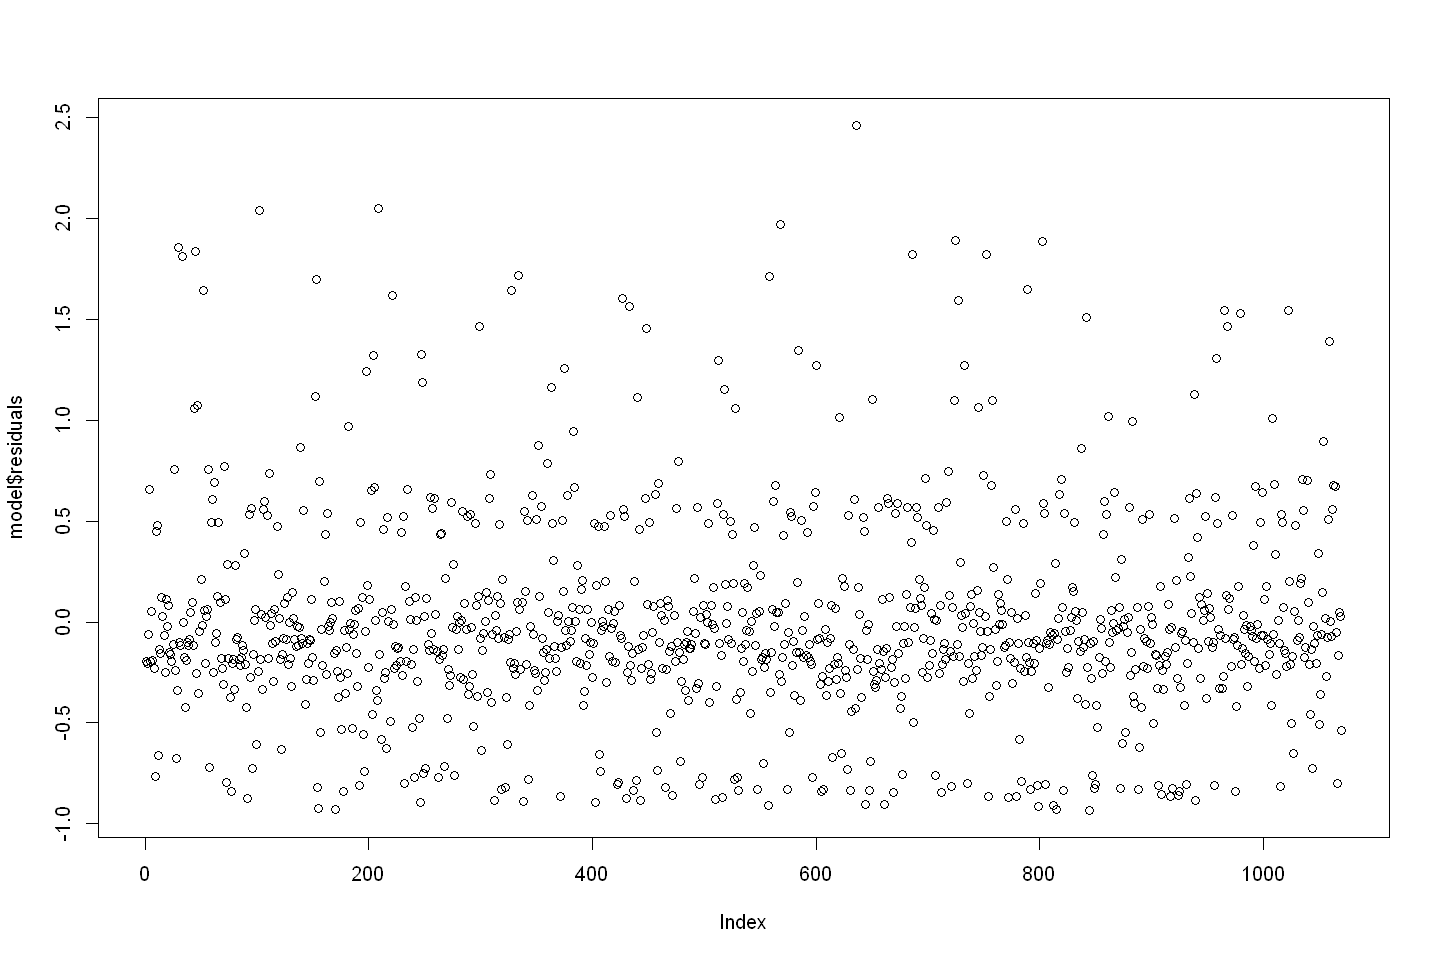

In [29]:
model=lm(charges~.,data = train)
summary(model)
plot(model$residuals)
pred=predict(model,test[,-4])
sum(abs((pred-test$charges)/test$charges))/nrow(test)

* From the above summary we can observe that the **p-value: 2.2e-16**. Since it less than 0.05 we can colnclude at 5% level of significance that the fitted linear regression model is significant.
* The model explains 75% of the total variation in the data. The performance of the model in explaining the variation in the data is not bad. 
- The residual plot looks random and the MAPE on the test set comes out to be 0.46 which is not bad. Let's see if we can improve this 

## Outlier detection

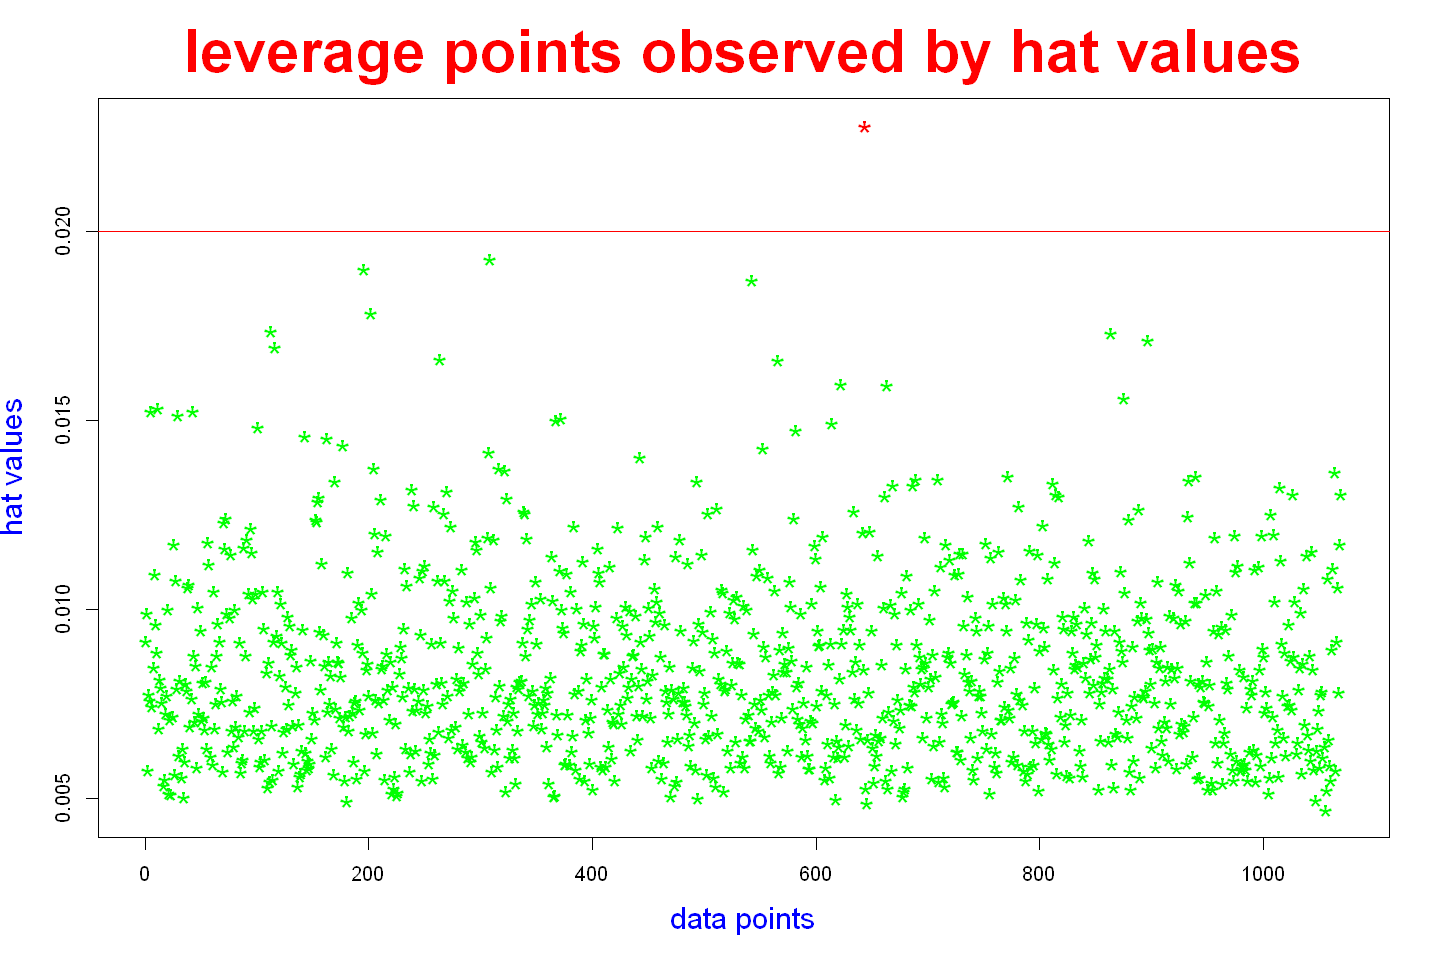

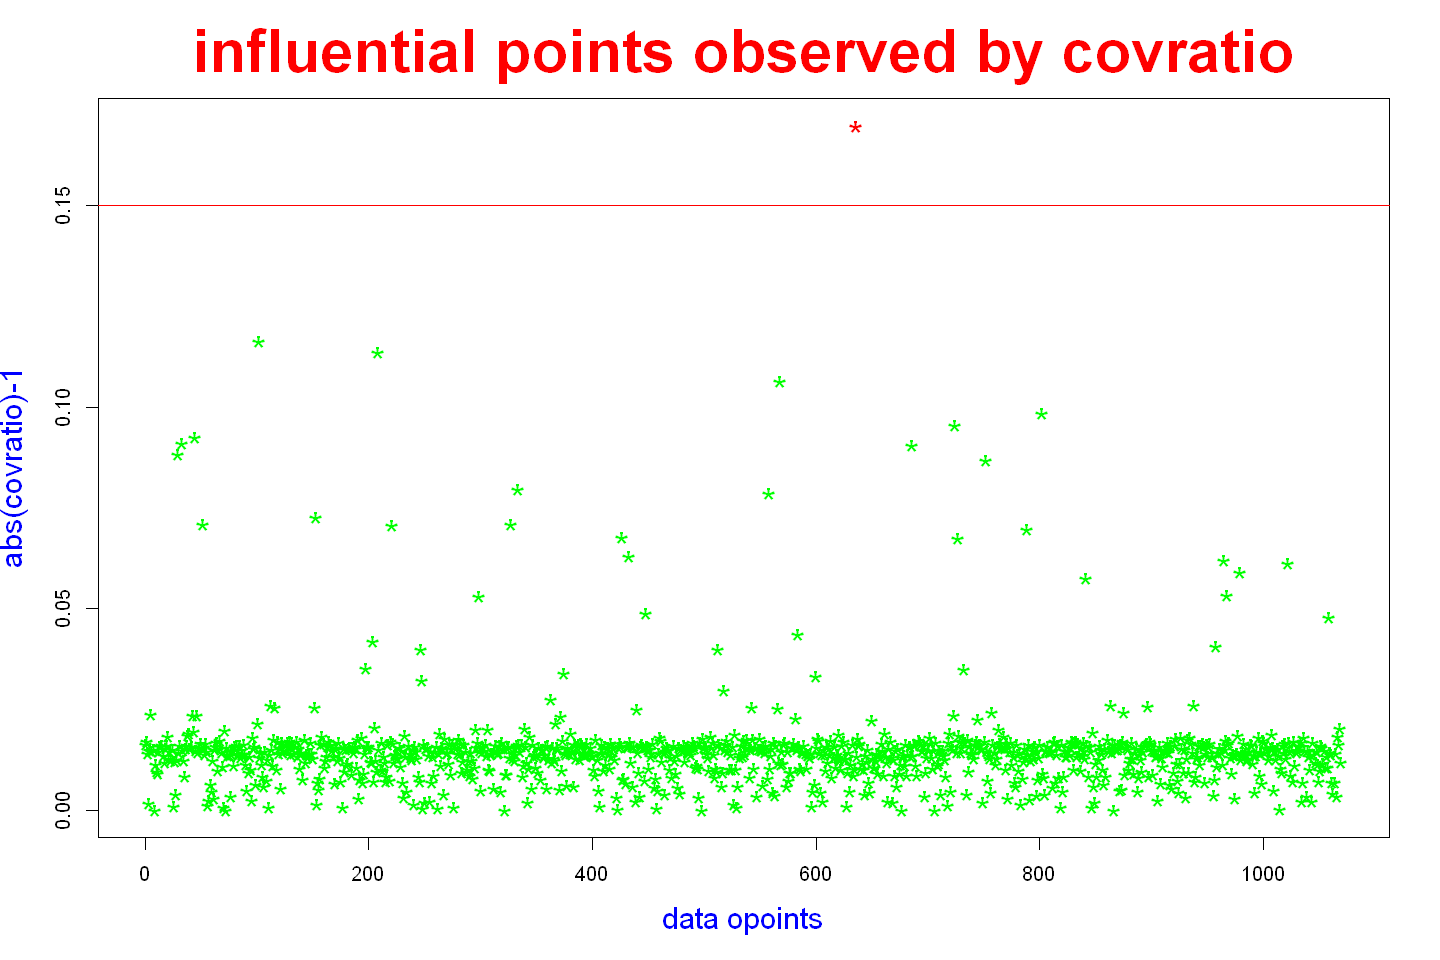

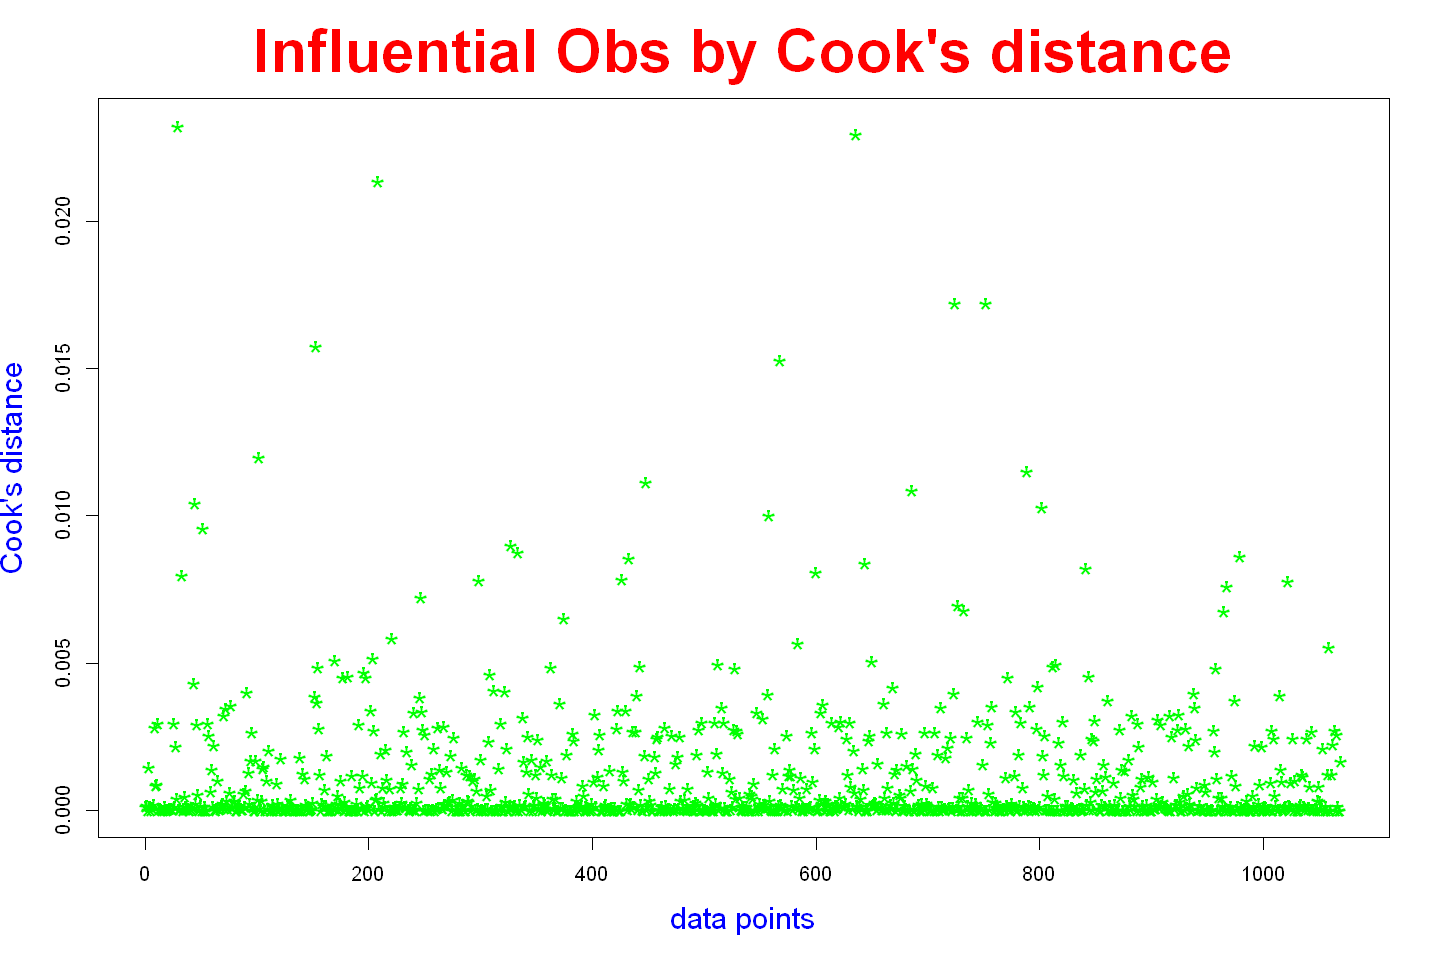

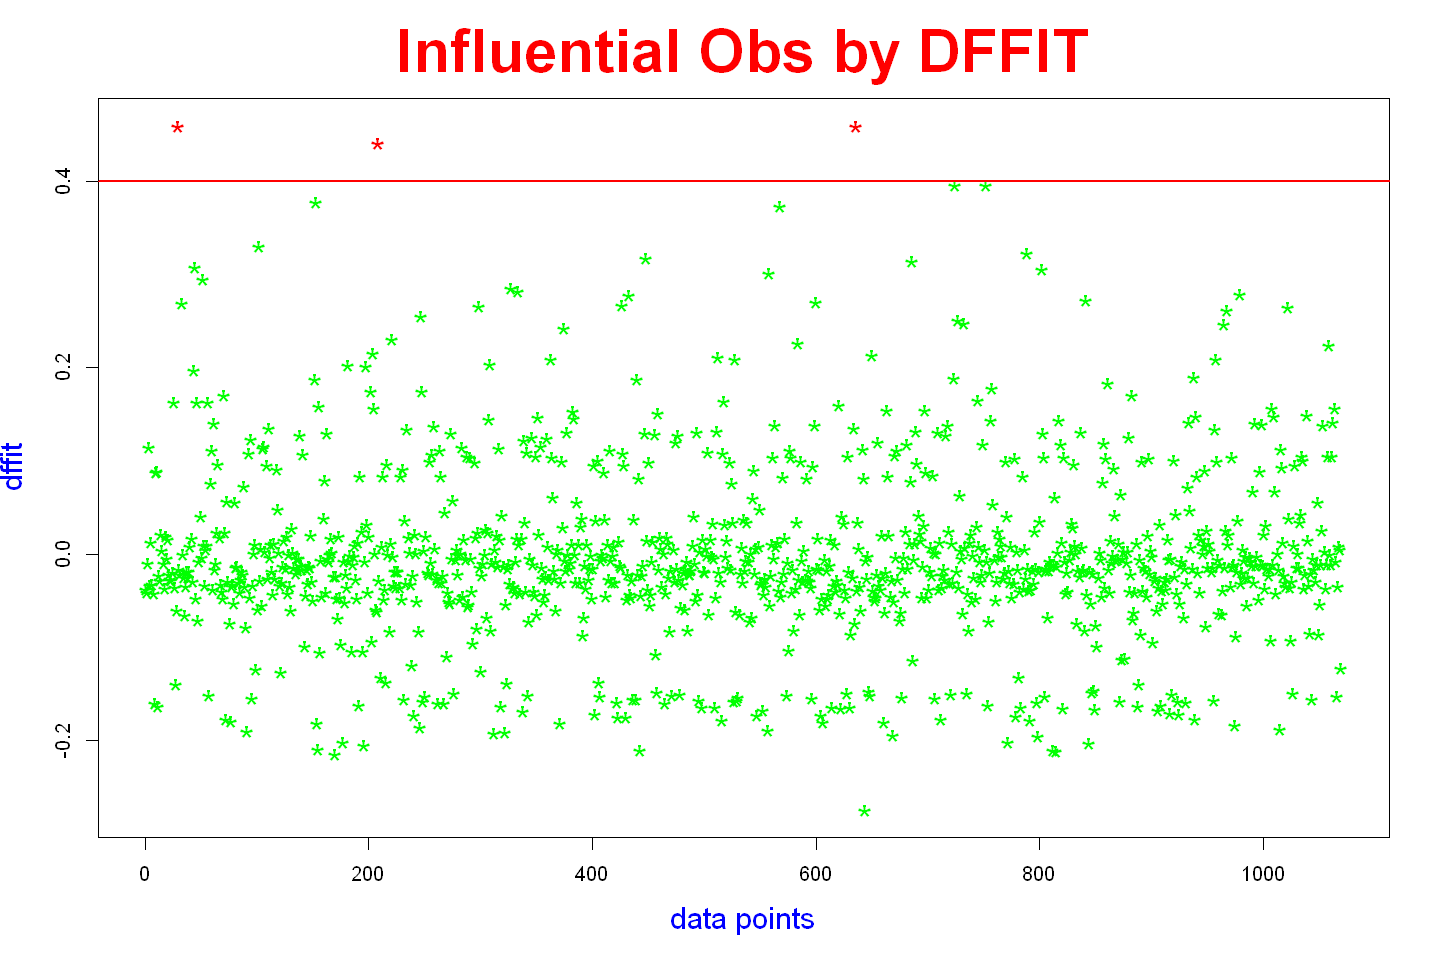

In [30]:
options(repr.plot.width= 12, repr.plot.height= 8)
#plot of hat_values
hat = hatvalues(model)
plot(hat, col = ifelse(hat > 0.02,"red","green") , pch = "*" , cex = 2, xlab=list("data points",cex=1.5,col="blue"), 
     ylab=list("hat values",cex=1.5,col="blue"))
title(main='leverage points observed by hat values',cex.main=3,col.main="red")
abline(h = 0.02,col = 'red')
ckd = cooks.distance(model)
cvratio = covratio(model)
dffit  = dffits(model)
# plot of covratio
plot(abs(cvratio-1), pch="*", cex=2,col = ifelse(abs(cvratio -1) > 0.15,"red","green"),
     xlab=list("data opoints",cex=1.5,col="blue"), 
     ylab=list("abs(covratio)-1",cex=1.5,col="blue"))  # plot covratio
title(main='influential points observed by covratio',cex.main=3,col.main="red")
abline(h = 0.15 , col="red")  # add cutoff line
#plot of cook's distance
plot(ckd, pch="*", cex=2,col = ifelse(ckd > .5,"red","green"), 
     xlab=list("data points",cex=1.5,col="blue"), 
     ylab=list("Cook's distance",cex=1.5,col="blue"))
title("Influential Obs by Cook's distance",cex.main=3,col.main="red")  # plot cook's distance
abline(h = .5 , col="red")  # add cutoff line
# plot of dffit values
plot(dffit, pch="*", cex=2,col = ifelse(abs(dffit) >.4,"red","green"),
     xlab=list("data points",cex=1.5,col="blue"), 
     ylab=list("dffit",cex=1.5,col="blue"))

title(main="Influential Obs by DFFIT",cex.main=3,col.main="red")  # plot dffit
abline(h = c(.4,-.4), col="red",lwd = c(2,2))  # add cutoff line


## Model fitting after removing leverage and influential points from the data

In [31]:
ckd_infl = which(ckd > 0.5)
covratio_infl = which(abs(cvratio-1) > .15)
dffit_infl = which(abs(dffit)>.4)
leverage_point=which(hat>0.02)
influential_points = union(union(ckd_infl,leverage_point),union(covratio_infl,dffit_infl))
# removing influential points
train_wo_infl = train[-influential_points,]
model2=lm(charges~.,data = train_wo_infl)
summary(model2)


Call:
lm(formula = charges ~ ., data = train_wo_infl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92406 -0.23353 -0.08219  0.12172  2.02978 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.069973   0.097094  -0.721    0.471    
age               0.020003   0.001099  18.200  < 2e-16 ***
bmi               0.170477   0.016107  10.584  < 2e-16 ***
children          0.051674   0.012647   4.086 4.72e-05 ***
sex_male         -0.006928   0.015268  -0.454    0.650    
smoker_yes        0.986056   0.018638  52.906  < 2e-16 ***
region_northwest -0.019424   0.021728  -0.894    0.372    
region_southeast -0.035754   0.021857  -1.636    0.102    
region_southwest -0.033528   0.021855  -1.534    0.125    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4944 on 1057 degrees of freedom
Multiple R-squared:  0.7561,	Adjusted R-squared:  0.7543 
F-statistic: 409.7 on 8 and 1057 DF,  p-value: < 2.

# Model assumptions checking

## 1. Checking homoscedasticity of error

                 Test stat Pr(>|Test stat|)    
age                 4.0227        6.163e-05 ***
bmi                -2.6359         0.008515 ** 
children           -0.1549         0.876891    
sex_male           -0.3801         0.703917    
smoker_yes         -0.3801         0.703917    
region_northwest   -0.3801         0.703917    
region_southeast   -0.3801         0.703917    
region_southwest   -0.3801         0.703917    
Tukey test         10.4492        < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

               Data                 
 -----------------------------------
 Response : charges 
 Variables: fitted values of charges 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    161.2143 
 Prob > Chi2   =    6.142588e-37 

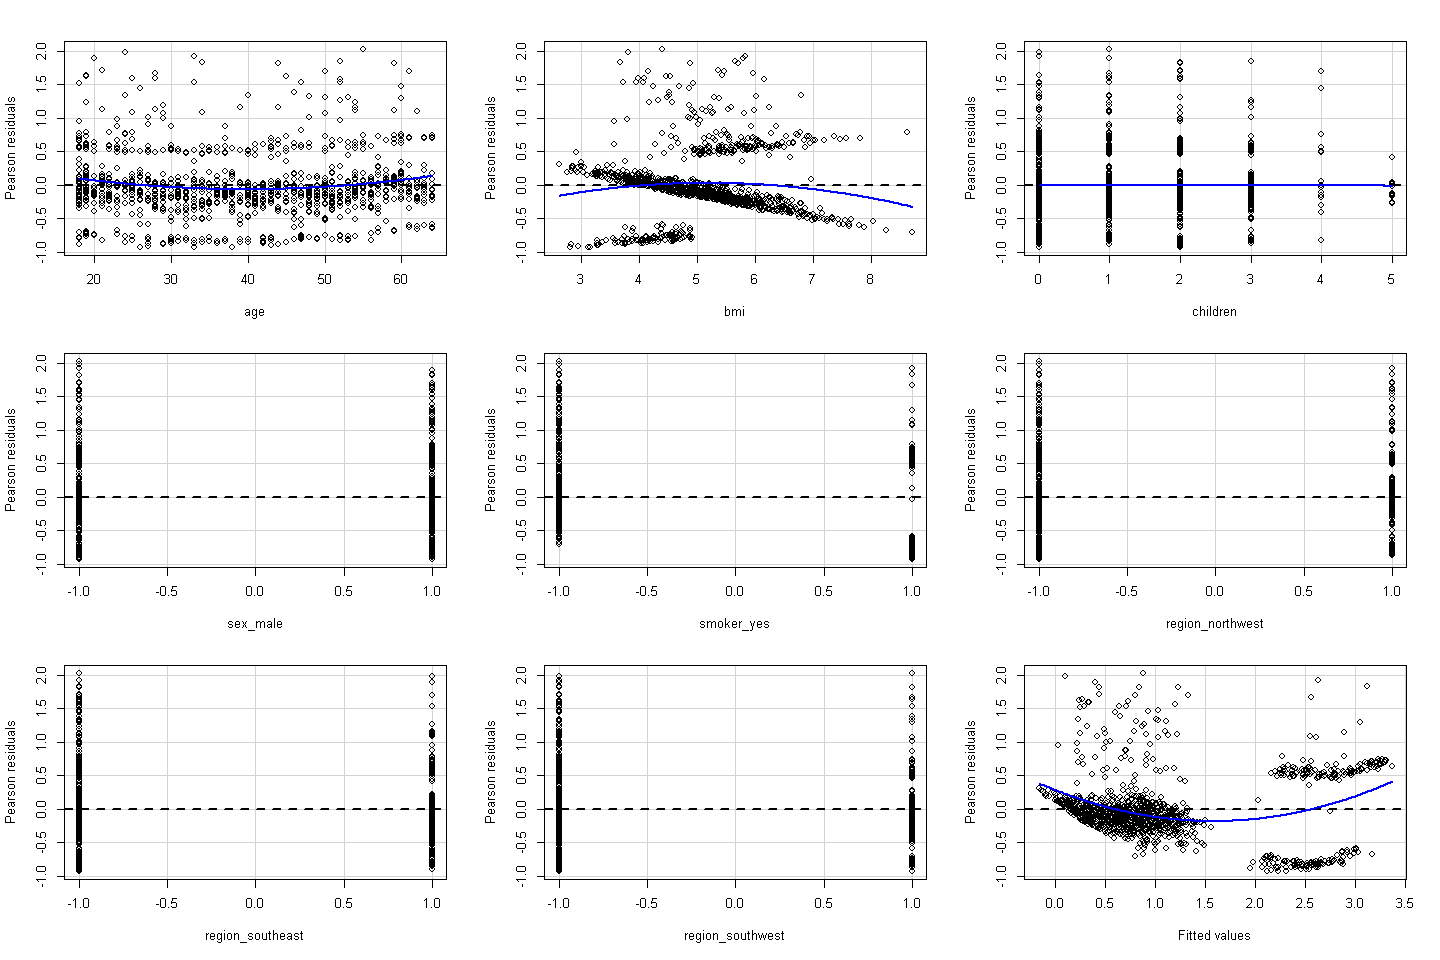

In [32]:
residualPlots(model2)
ols_test_breusch_pagan(model2)


Call:
lm(formula = charges ~ ., data = new_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24303 -0.05046 -0.02735  0.01327  0.48937 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.556e-01  9.524e-03  16.334  < 2e-16 ***
age               1.912e-02  1.023e-03  18.687  < 2e-16 ***
children          4.072e-02  1.223e-02   3.328 0.000903 ***
sex_male          6.043e-07  1.483e-02   0.000 0.999968    
smoker_yes        8.430e-01  1.801e-02  46.810  < 2e-16 ***
region_northwest  1.607e-03  1.953e-02   0.082 0.934431    
region_southeast -9.017e-03  1.952e-02  -0.462 0.644163    
region_southwest -1.118e-02  1.975e-02  -0.566 0.571423    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1013 on 1058 degrees of freedom
Multiple R-squared:  0.7024,	Adjusted R-squared:  0.7005 
F-statistic: 356.8 on 7 and 1058 DF,  p-value: < 2.2e-16


                 Test stat Pr(>|Test stat|)    
age                 1.9905           0.0468 *  
children           -0.9575           0.3386    
sex_male           -1.8410           0.0659 .  
smoker_yes         -1.8410           0.0659 .  
region_northwest   -1.8410           0.0659 .  
region_southeast   -1.8410           0.0659 .  
region_southwest   -1.8410           0.0659 .  
Tukey test         -8.7879           <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

               Data                 
 -----------------------------------
 Response : charges 
 Variables: fitted values of charges 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    189.8263 
 Prob > Chi2   =    3.469249e-43 

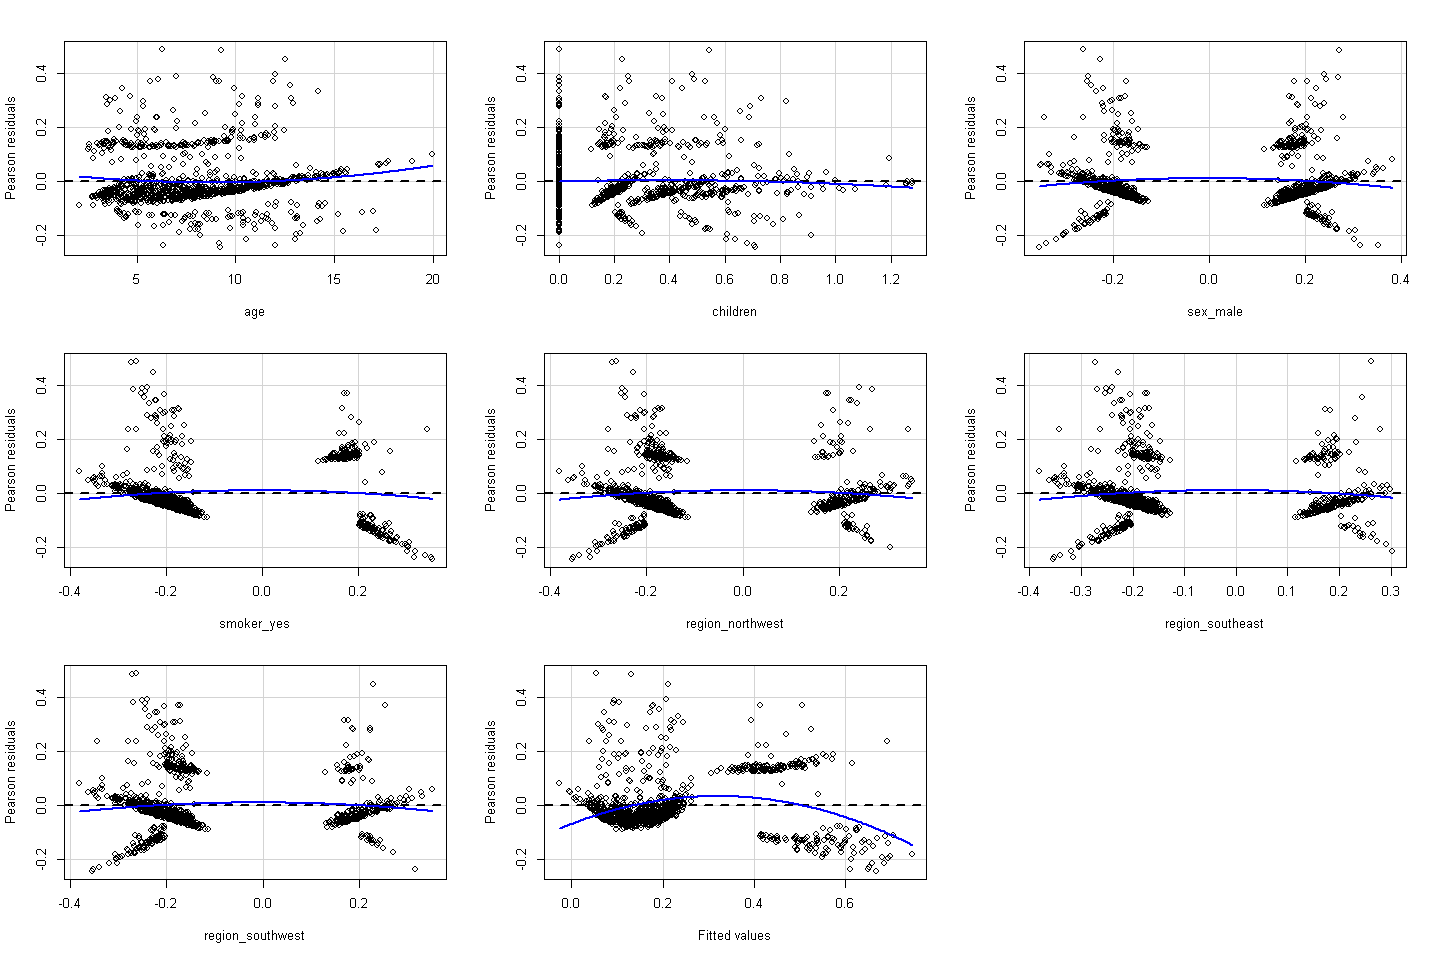

In [50]:
new_data=train_wo_infl/train_wo_infl$bmi
new_data=new_data[,-2]
model3=lm(charges~.,data = new_data)
summary(model3)
residualPlots(model3)
ols_test_breusch_pagan(model3)

- There is no prominent pattern in these plots. We can say that problem of heteroscedasticity is removed

## 2. Normality of errors

220 141 
566  44

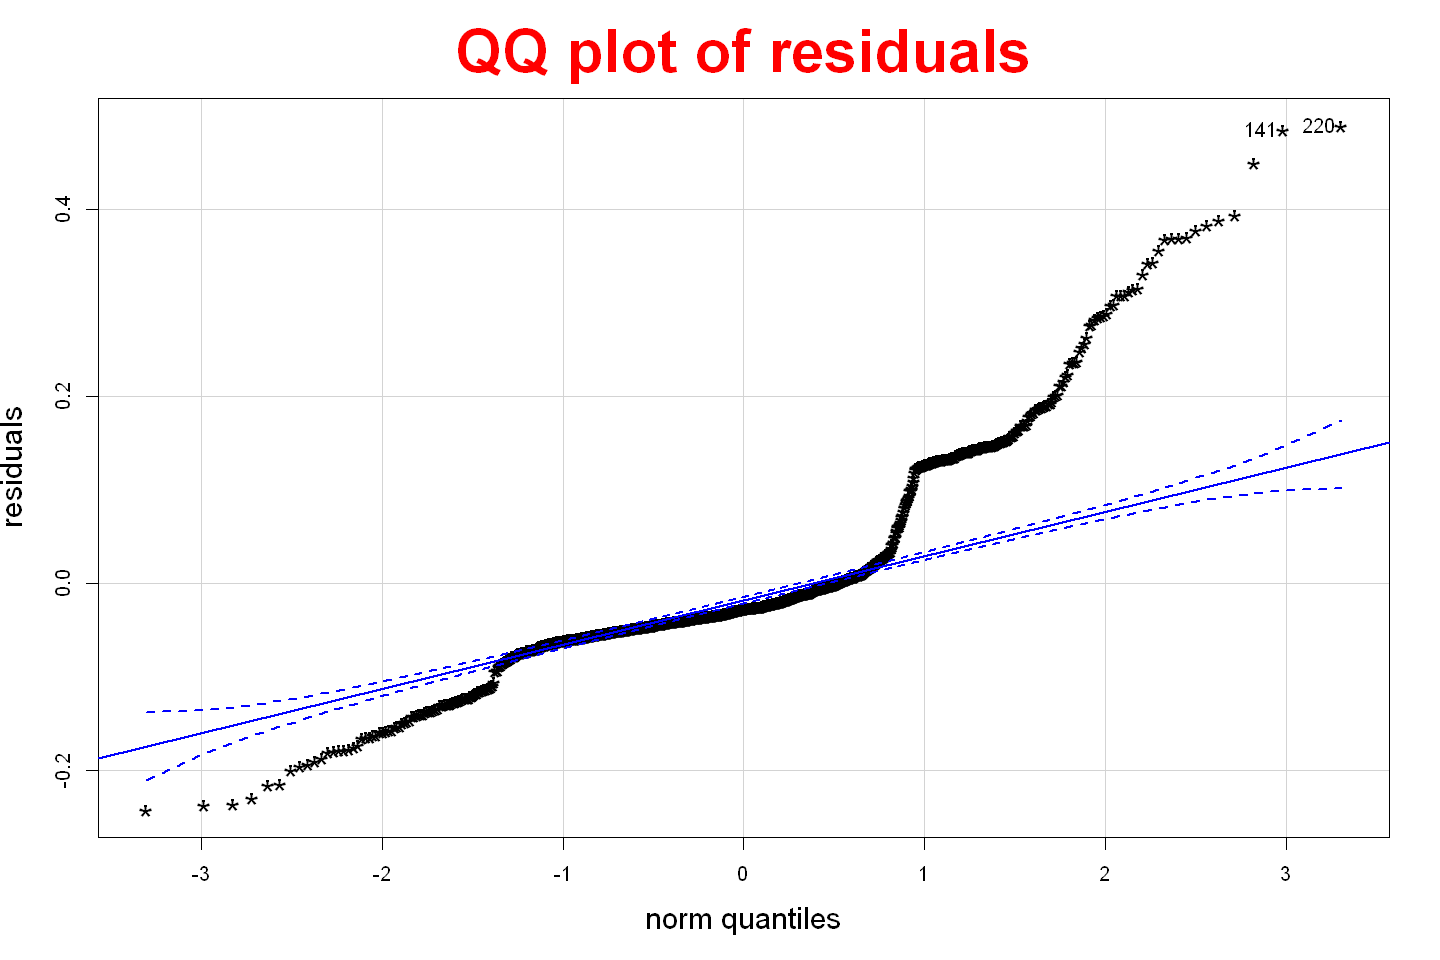

In [51]:
res3=model3$residuals
qqPlot(res3,ylab=list("residuals",cex=1.5),xlab=list("norm quantiles",cex=1.5), pch = '*' , cex = 2)
title(main="QQ plot of residuals",cex.main=3,col.main="red")

- Error distribution is far deviated from normal distribution. So we apply box-cox trnasformation to the response

Box-Cox Transformation 

Estimation method:  ml  
Optimal parameter:  0.2124711  
Loglike:  -2769.825 

Summary of transformed variables 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.90026 -1.93854 -1.53186 -1.49403 -1.03356 -0.07426 

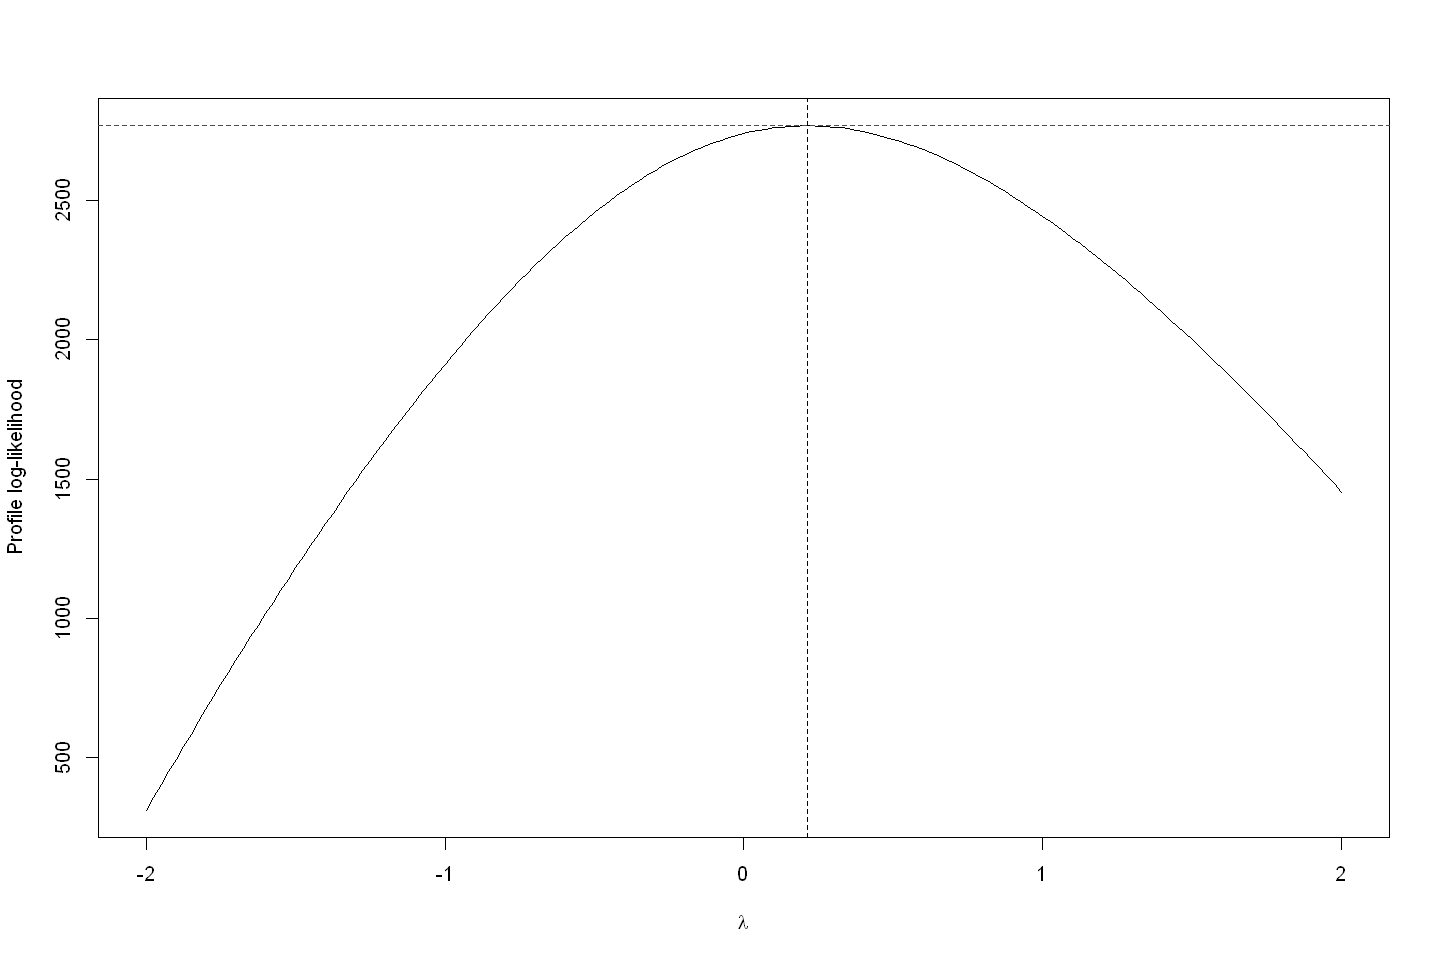

[1] 748 721

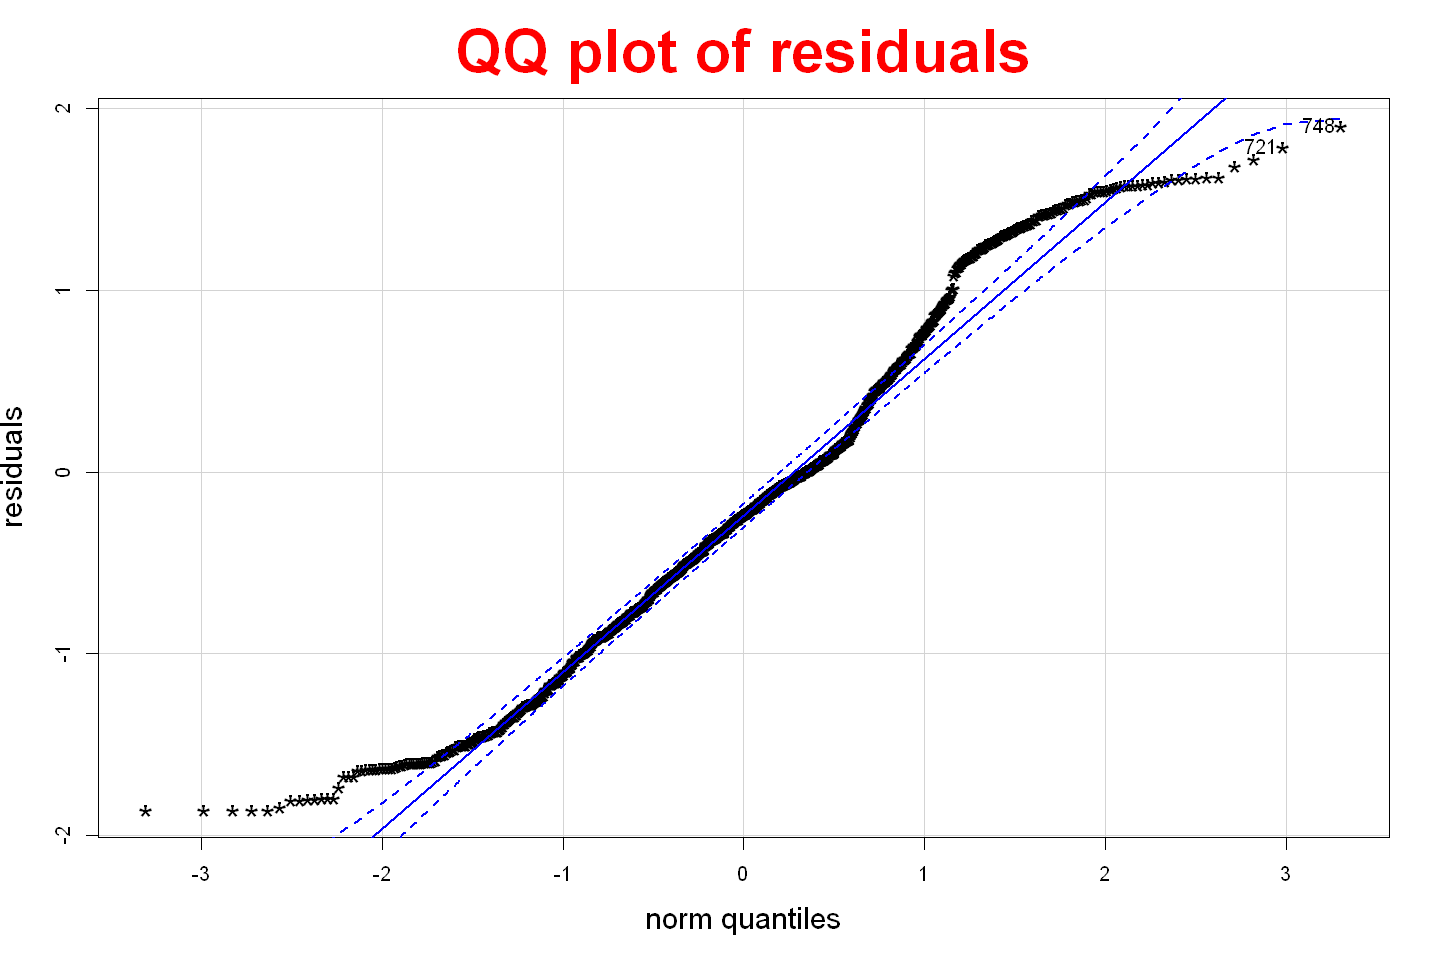

In [52]:
obj=boxcox(model3,plotit = TRUE)
obj
lambda=0.2124711
y_transformed=(train_wo_infl$charges^lambda-1)/lambda
qqPlot(y_transformed,ylab=list("residuals",cex=1.5),xlab=list("norm quantiles",cex=1.5), pch = '*' , cex = 2)
title(main="QQ plot of residuals",cex.main=3,col.main="red")

- The QQ plot looks now somewhat similar to the normal distribution. So we transform the response and do further analysis

## Fitting model after box-cox transformation

In [61]:
train_wo_infl$charges=y_transformed
model4=lm(charges~.,data = train_wo_infl)
summary(model4)
res4=model4$residuals
shapiro.test(res4)


Call:
lm(formula = charges ~ ., data = train_wo_infl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.89504 -0.20902 -0.06359  0.04902  1.99995 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.5237192  0.0809990 -18.812  < 2e-16 ***
age               0.0287431  0.0009169  31.348  < 2e-16 ***
bmi               0.0973307  0.0134372   7.243 8.42e-13 ***
children          0.0829890  0.0105504   7.866 9.01e-15 ***
sex_male         -0.0295236  0.0127367  -2.318 0.020640 *  
smoker_yes        0.7859184  0.0155482  50.547  < 2e-16 ***
region_northwest -0.0327902  0.0181263  -1.809 0.070737 .  
region_southeast -0.0631181  0.0182338  -3.462 0.000558 ***
region_southwest -0.0537488  0.0182323  -2.948 0.003269 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4125 on 1057 degrees of freedom
Multiple R-squared:  0.7752,	Adjusted R-squared:  0.7735 
F-statistic: 455.6 on 8 and 1057 DF,  p-v


	Shapiro-Wilk normality test

data:  res4
W = 0.82364, p-value < 2.2e-16


## 3. Multicollinearity checking

In [62]:
ols_coll_diag(model4)

Tolerance and Variance Inflation Factor
---------------------------------------
         Variables Tolerance      VIF
1              age 0.9841201 1.016136
2              bmi 0.8979404 1.113660
3         children 0.9969407 1.003069
4         sex_male 0.9853073 1.014912
5       smoker_yes 0.9911197 1.008960
6 region_northwest 0.6602005 1.514691
7 region_southeast 0.6072833 1.646678
8 region_southwest 0.6542600 1.528444


Eigenvalue and Condition Index
------------------------------
  Eigenvalue Condition Index    intercept          age          bmi
1 4.57793566        1.000000 1.108774e-03 4.682033e-03 1.484647e-03
2 1.06952595        2.068898 8.392325e-09 3.427661e-06 7.173998e-05
3 0.99976583        2.139862 9.557623e-08 1.604247e-06 9.372081e-07
4 0.96180444        2.181682 1.107949e-06 1.278016e-06 5.155502e-06
5 0.61782573        2.722086 2.479752e-04 1.316419e-03 2.913217e-04
6 0.47544828        3.103010 1.601955e-03 8.532890e-03 2.071484e-03
7 0.20772148        4.694552 4.425451e

- All the VIF's are less than 5. Hence there are no multicollinearity present in the data

# Selection of predictors
## 1. Forward Selection

In [63]:
ols_step_forward_p(model4)


                                 Selection Summary                                   
------------------------------------------------------------------------------------
        Variable                          Adj.                                          
Step        Entered         R-Square    R-Square      C(p)          AIC        RMSE     
------------------------------------------------------------------------------------
   1    smoker_yes            0.5214      0.5209    1188.5061    1939.6145    0.5999    
   2    age                   0.7492      0.7487     119.4985    1252.9084    0.4345    
   3    children              0.7622      0.7616      59.9716    1197.7992    0.4232    
   4    bmi                   0.7712      0.7703      19.8290    1158.8387    0.4153    
   5    region_southeast      0.7723      0.7712      16.8408    1155.8846    0.4146    
   6    region_southwest      0.7734      0.7722      13.3354    1152.3900    0.4137    
   7    sex_male              0

## 2. Backward Elimination

In [66]:
ols_step_backward_p(model4)

[1] "No variables have been removed from the model."

## Checking importance of regressors

In [67]:
print(ols_correlations(model4))

                   Correlations                     
---------------------------------------------------
Variable            Zero Order    Partial     Part  
---------------------------------------------------
age                      0.453      0.694     0.457 
bmi                      0.147      0.217     0.106 
children                 0.127      0.235     0.115 
sex_male                 0.023     -0.071    -0.034 
smoker_yes               0.722      0.841     0.737 
region_northwest        -0.026     -0.056    -0.026 
region_southeast         0.020     -0.106    -0.050 
region_southwest        -0.034     -0.090    -0.043 
---------------------------------------------------


- Smoker is the most important regressor in predicting medical charges

MAPE for the test set in the final model

In [68]:
pred_4=predict(model4,test[,-4])
pred_4_original=(lambda*pred_4+1)^(1/lambda)
sum(abs((pred_4_original-test$charges)/test$charges))/nrow(test)

[1] 0.2848522

* From the above summary we can observe that the **p-value: 2.2e-16**. Since it less than 0.05 we can colnclude at 5% level of significance that the fitted linear regression model is significant.
* The model explains 77% of the total variation in the data. The performance of the model in explaining the variation in the data is not bad. 
- The residual plot looks random and the MAPE on the test set comes out to be 0.28 which is not satisfactory.

# Conclusion

From the analysis we can say that if a person don't get into the smoking habit and also restrict his/her number of children then the person can reduce his/her medical charges